# Setting up

In [5]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt

from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Goals:
    - check if small2zero(A) * small2zero(B) = small2zero(A * B) for different operations
    - check how much does it change with partial transpose.
    - how does this operation affect the number of singular values
    - for our uses case, how much does it reduce the sparsity.

In [6]:
from opentn.optimization import small2zero

In [144]:
# I think it is important to know what are the min, max values, singular values, rank and norm of the operators we are dealing with
for op in [X1, X2, rhs]:
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('min neg: ', np.where(op < 0, op, -np.inf).max())
    print('min pos:', np.where(op > 0, op, np.inf).min()) # finding the minimum positive value!
    print('max:', np.max(op))
    print('singular values:', np.linalg.svd(op, compute_uv=False)[:rank+2])
    print('norm:', np.linalg.norm(op, 'fro'))
    print(f'norm from highest {rank//2} singular values:', np.sqrt(np.sum(np.linalg.svd(op, compute_uv=False)[:rank//2]**2)))
    print('----')

rank: 4
min neg:  (-5.537260436080078e-19+0j)
min pos: (5.156975645646526e-27+0j)
max: (1.0000000000000004+0j)
singular values: [3.99501248e+00 1.41156678e-01 1.41156678e-01 4.98752081e-03
 1.25777257e-15 1.17040949e-15]
norm: 4.0
norm from highest 2 singular values: 3.99750546175621
----
rank: 2
min neg:  (-1.2320728564909808e-17+0j)
min pos: (1.547094305247636e-26+0j)
max: (1.0000000000000004+0j)
singular values: [3.99502182e+00 1.99501040e-01 2.15563454e-16 1.78409424e-17]
norm: 4.000000000000001
norm from highest 1 singular values: 3.995021819088937
----
rank: 29
min neg:  (-5.368020793234573e-18+0j)
min pos: (4.022496586591944e-15+0j)
max: (1+0j)
singular values: [1.58809071e+01 5.35571431e-02 3.96274662e-02 2.56236967e-02
 1.19766269e-04 4.95029797e-05 4.94826258e-05 4.08201317e-05
 2.47515434e-05 8.95308390e-08 7.94678759e-08 5.63855416e-08
 4.35119228e-08 1.83024667e-08 1.61593460e-08 8.50200641e-09
 9.97181427e-11 6.72506539e-11 3.81643857e-11 3.10065794e-11
 3.03003047e-11 2.

In [145]:
# lets do the same test but applying small2zero beforehand
tol = 1e-6
for op in [X1, X2, rhs]:
    op = small2zero(op, tol)
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('min neg: ', np.where(op < 0, op, -np.inf).max())
    print('min pos:', np.where(op > 0, op, np.inf).min()) # finding the minimum positive value!
    print('max:', np.max(op))
    print('norm:', np.linalg.norm(op, 'fro'))
    print(f'norm from highest {rank//2} singular values:', np.sqrt(np.sum(np.linalg.svd(op, compute_uv=False)[:rank//2]**2)))
    print('----')

rank: 4
min neg:  (-6.234365203127406e-05+0j)
min pos: (1.5585994405163202e-06+0j)
max: (1.0000000000000004+0j)
norm: 3.9999999999999787
norm from highest 2 singular values: 3.9975054617561994
----
rank: 2
min neg:  (-0.04987526002646981+0j)
min pos: (0.002493760403658844+0j)
max: (1.0000000000000004+0j)
norm: 4.000000000000001
norm from highest 1 singular values: 3.995021819088937
----
rank: 56
min neg:  (-3.0836264850127697e-06+0j)
min pos: (3.0784972489169335e-06+0j)
max: (1+0j)
norm: 15.88106747962257
norm from highest 28 singular values: 15.881067479622569
----


In [149]:
# the question then arises, why does the rank increase when the small2zero is implemented?
tol = 1e-4
for op in [rhs, X1, X2]:
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('singular values:', np.linalg.svd(op, compute_uv=False)[:rank+2])
    op = small2zero(op, tol)
    rank = np.linalg.matrix_rank(op)
    print('rank:', rank)
    print('singular values:', np.linalg.svd(op, compute_uv=False)[:rank+2])
    print('-----')

# NOTE: interestingly from this we notice that the tolerance needs to be set at the same order of magnitude as the smallest original singular value (within rank) for the reduced matrix to not be affected. Here 1e-12 for rhs. For X1, X2 this does not matter because their lowest significant value is on 1e-4


print('NORM DIFFERENCES FOR RHS')

tols = []
# are the matrices actually different?
norm_rhs = np.linalg.norm(rhs)
rel_errors_rhs = []
min_tol = 1
max_tol = 22
for exponent in range(min_tol,max_tol):
    tol = 10**(-exponent)
    rel_error = np.linalg.norm(small2zero(rhs, tol) - rhs)/norm_rhs
    print('tol: ', tol, ':', rel_error)
    tols.append(tol)
    rel_errors_rhs.append(rel_error)

rel_errors_x1x2 = np.zeros(shape=(2, len(tols)))
for i, op in enumerate([X1, X2]):
    for j, tol in enumerate(tols):
        rel_error = np.linalg.norm(small2zero(op, tol) - op)/np.linalg.norm(op)
        rel_errors_x1x2[i,j] = rel_error


# NOTE: The norm just seems to keep decreasing?

rank: 29
singular values: [1.58809071e+01 5.35571431e-02 3.96274662e-02 2.56236967e-02
 1.19766269e-04 4.95029797e-05 4.94826258e-05 4.08201317e-05
 2.47515434e-05 8.95308390e-08 7.94678759e-08 5.63855416e-08
 4.35119228e-08 1.83024667e-08 1.61593460e-08 8.50200641e-09
 9.97181427e-11 6.72506539e-11 3.81643857e-11 3.10065794e-11
 3.03003047e-11 2.54318080e-11 1.61714159e-11 1.36575963e-11
 9.42663336e-12 8.05076581e-12 5.29058301e-12 4.12488291e-12
 3.30513856e-12 1.37834055e-13 6.09793590e-14]
rank: 35
singular values: [1.58809071e+01 5.35570105e-02 3.96273130e-02 2.56235846e-02
 8.48104978e-05 8.27402896e-05 7.03342853e-05 6.18685251e-05
 3.89681834e-05 3.89501502e-05 3.82430510e-05 3.03300081e-05
 3.02670703e-05 2.19923190e-05 2.14909921e-05 1.32334500e-05
 1.19172618e-05 1.18669015e-05 8.13558674e-06 6.47616082e-06
 4.40350220e-06 2.88417053e-06 6.02408494e-08 5.02181143e-08
 3.09022181e-08 1.70728289e-08 7.72838795e-09 7.72570975e-09
 7.72413158e-09 6.58332517e-11 4.69688736e-11 4

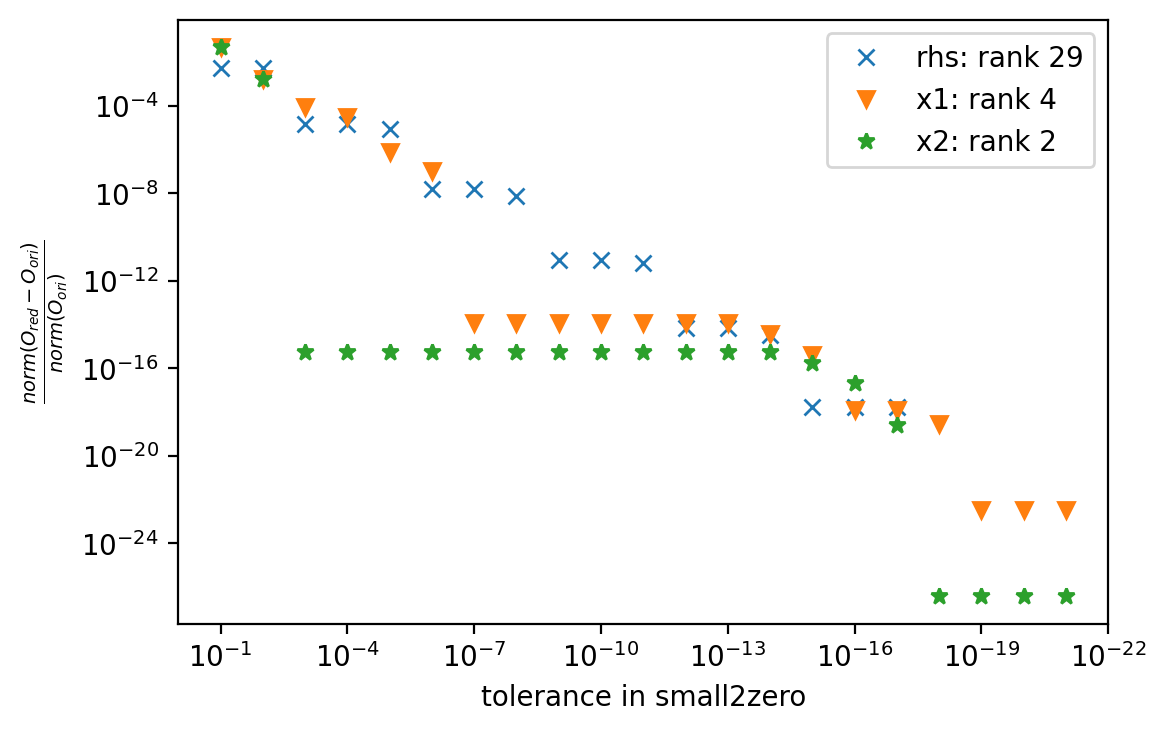

In [161]:
# here I want to make a plot showing the RELATIVE error for RHS, X1, X2 in terms of the tolerance
import matplotlib.pyplot

plt.figure(dpi=200)
plt.ylabel(r'$\frac{norm(O_{red} - O_{ori})}{norm(O_{ori})}$')
plt.xlabel('tolerance in small2zero')
plt.loglog(tols, rel_errors_rhs, 'x' ,label='rhs: rank 29')
plt.loglog(tols, rel_errors_x1x2[0,:], 'v' ,label='x1: rank 4')
plt.loglog(tols, rel_errors_x1x2[1,:], '*' ,label='x2: rank 2')
plt.legend()
plt.gca().invert_xaxis()

In [152]:
import scipy.sparse as sparse
eps = np.finfo(np.complex128).eps

# how much does the sparsity actually decrease when using/not using the small2zero function

nz_rhs = sparse.csc_matrix(rhs).count_nonzero()
nz_x1 = sparse.csc_matrix(X1).count_nonzero()
nz_x2 = sparse.csc_matrix(X2).count_nonzero()

nz_ops = [nz_x1, nz_x2, nz_rhs]

nz_ops_tol = np.zeros(shape=(3,len(tols)))

for i, op in enumerate([X1, X2, rhs]):
    for j, tol in enumerate(tols):
        nz_op_tol = sparse.csc_matrix(small2zero(op, tol)).count_nonzero()
        nz_ops_tol[i, j] = nz_op_tol/nz_ops[i]

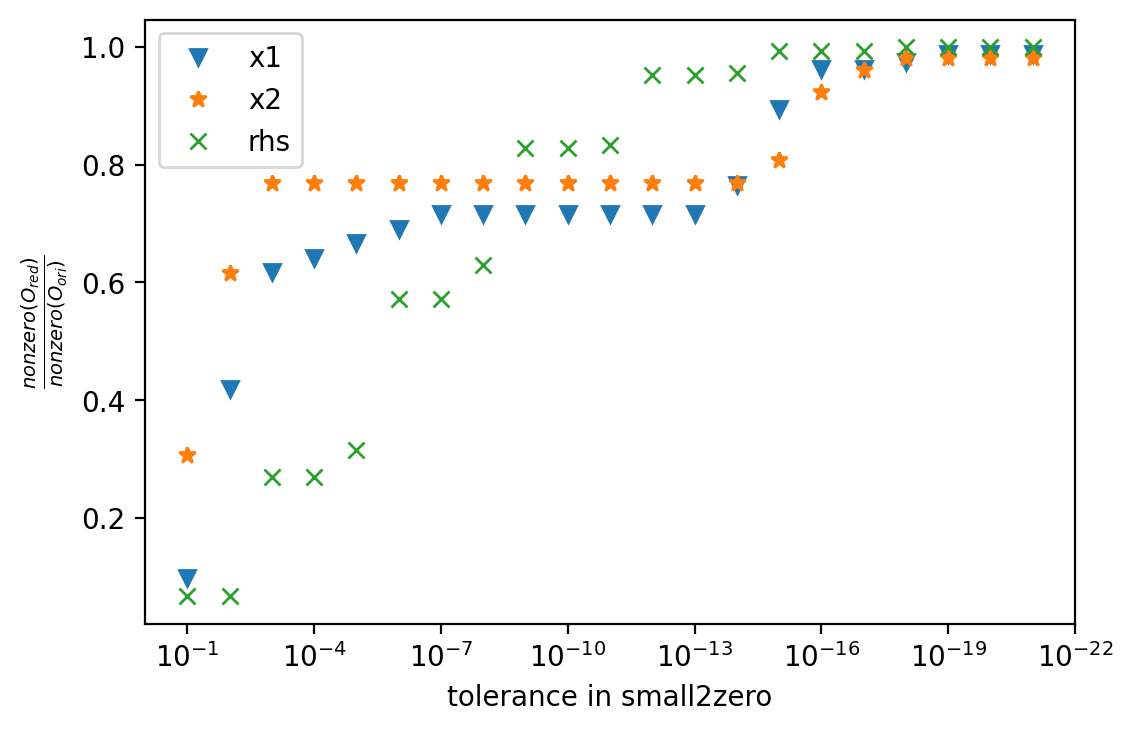

In [168]:
plt.figure(dpi=200)
plt.ylabel(r'$\frac{nonzero(O_{red})}{nonzero(O_{ori})}$')
plt.xlabel('tolerance in small2zero')
plt.semilogx(tols, nz_ops_tol[0,:], 'v' ,label='x1')
plt.semilogx(tols, nz_ops_tol[1,:], '*' ,label='x2')
plt.semilogx(tols, nz_ops_tol[2,:], 'x' ,label='rhs')
plt.legend()
plt.gca().invert_xaxis()

In [181]:
nz_ops_tol[-1,11], nz_ops_tol[-1,11]*nz_ops[-1] ,nz_ops[-1]

(0.9527310924369747, 3628.0, 3808)

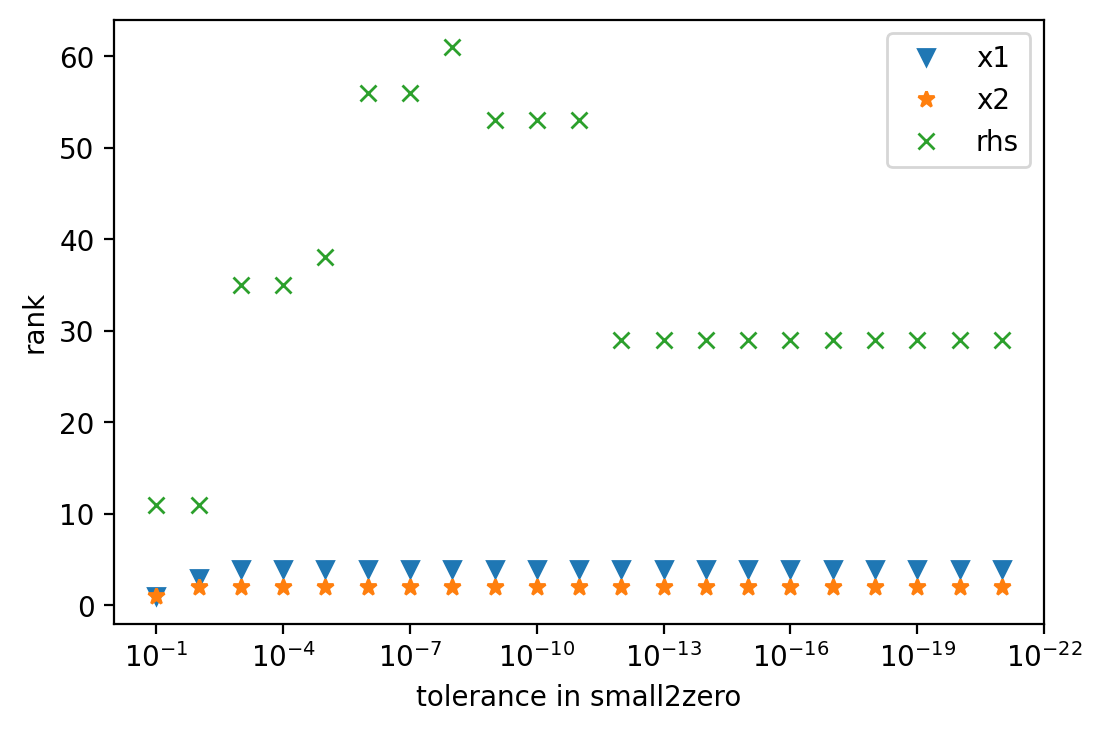

In [169]:
# lastly, how does the rank changes with the tolerance

rank_op_tol = np.zeros(shape=(3,len(tols)))
for i, op in enumerate([X1, X2, rhs]):
    for j, tol in enumerate(tols):
        rank_op_tol[i, j] = np.linalg.matrix_rank(small2zero(op, tol))

plt.figure(dpi=200)
plt.ylabel('rank')
plt.xlabel('tolerance in small2zero')
plt.semilogx(tols, rank_op_tol[0,:], 'v' ,label='x1')
plt.semilogx(tols, rank_op_tol[1,:], '*' ,label='x2')
plt.semilogx(tols, rank_op_tol[2,:], 'x' ,label='rhs')
plt.legend()
plt.gca().invert_xaxis()

In [173]:
# check for multiplication of matrices
from opentn.transformations import choi_composition

op1 = X1
op2 = rhs

print('multiplication')
for tol in tols:
    print('tol: ', tol, ':', np.allclose(small2zero(op1, tol) @ small2zero(op2, tol), small2zero(op1@op2), tol))

# what happens to the singular values when doing the small2zero transformation:
print('composition')
for tol in tols:
    print('tol: ', tol, ':', np.allclose(choi_composition(small2zero(op1, tol), small2zero(op2, tol)), small2zero(choi_composition(op1,op2)), tol))


multiplication
tol:  0.1 : False
tol:  0.01 : False
tol:  0.001 : False
tol:  0.0001 : False
tol:  1e-05 : False
tol:  1e-06 : True
tol:  1e-07 : True
tol:  1e-08 : True
tol:  1e-09 : True
tol:  1e-10 : True
tol:  1e-11 : True
tol:  1e-12 : True
tol:  1e-13 : True
tol:  1e-14 : True
tol:  1e-15 : True
tol:  1e-16 : True
tol:  1e-17 : True
tol:  1e-18 : True
tol:  1e-19 : True
tol:  1e-20 : True
tol:  1e-21 : True
composition
tol:  0.1 : False
tol:  0.01 : False
tol:  0.001 : False
tol:  0.0001 : False
tol:  1e-05 : False
tol:  1e-06 : False
tol:  1e-07 : True
tol:  1e-08 : True
tol:  1e-09 : True
tol:  1e-10 : True
tol:  1e-11 : True
tol:  1e-12 : True
tol:  1e-13 : True
tol:  1e-14 : True
tol:  1e-15 : True
tol:  1e-16 : True
tol:  1e-17 : True
tol:  1e-18 : True
tol:  1e-19 : True
tol:  1e-20 : True
tol:  1e-21 : True
